# Time Series with Deep Learning: CNN + LSTM

**Date:** 30 October 2025

**Topic:** Advanced time series forecasting using Convolutional Neural Networks and Long Short-Term Memory networks

This notebook covers:
1. Time Series Data Preparation for Deep Learning
2. Supervised Window Creation for Sequential Data
3. 1D Convolutional Neural Networks for Time Series
4. LSTM Networks for Sequential Pattern Recognition
5. Hybrid CNN-LSTM Architecture
6. Model Comparison and Performance Analysis

## 1. Setup and Dependencies

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Synthetic Sales Dataset Generation

### 2.1 Creating Store Sales Time Series

In [3]:
# Generate synthetic sales data similar to store-item sales
np.random.seed(42)

# Generate 5 years of daily sales data
n_days = 5 * 365  # 5 years
dates = pd.date_range(start='2018-01-01', periods=n_days, freq='D')

# Base sales pattern with trend and seasonality
t = np.arange(n_days)
trend = 0.001 * t + 10  # Slight upward trend
seasonal = 3 * np.sin(2 * np.pi * t / 365)  # Annual seasonality
weekly = 1.5 * np.sin(2 * np.pi * t / 7)    # Weekly pattern
noise = np.random.normal(0, 1.5, n_days)     # Random noise

# Combine components to create sales data
sales = trend + seasonal + weekly + noise
sales = np.maximum(sales, 1)  # Ensure positive sales
sales = np.round(sales).astype(int)  # Integer sales values

# Create DataFrame
sales_data = pd.DataFrame({
    'date': dates,
    'store': 1,
    'item': 1,
    'sales': sales
})

print(f"Generated Sales Dataset:")
print(f"Total days: {len(sales_data)}")
print(f"Date range: {sales_data['date'].min()} to {sales_data['date'].max()}")
print(f"Sales statistics:")
print(f"  Mean: {sales_data['sales'].mean():.2f}")
print(f"  Std: {sales_data['sales'].std():.2f}")
print(f"  Min: {sales_data['sales'].min()}")
print(f"  Max: {sales_data['sales'].max()}")

display(sales_data.head(10))

Generated Sales Dataset:
Total days: 1825
Date range: 2018-01-01 00:00:00 to 2022-12-30 00:00:00
Sales statistics:
  Mean: 10.97
  Std: 2.78
  Min: 3
  Max: 19


,date,store,item,sales
0,2018-01-01,1,1,11
1,2018-01-02,1,1,11
2,2018-01-03,1,1,13
3,2018-01-04,1,1,13
4,2018-01-05,1,1,9
5,2018-01-06,1,1,8
6,2018-01-07,1,1,12
7,2018-01-08,1,1,12
8,2018-01-09,1,1,11
9,2018-01-10,1,1,13


### 2.2 Sales Data Visualization

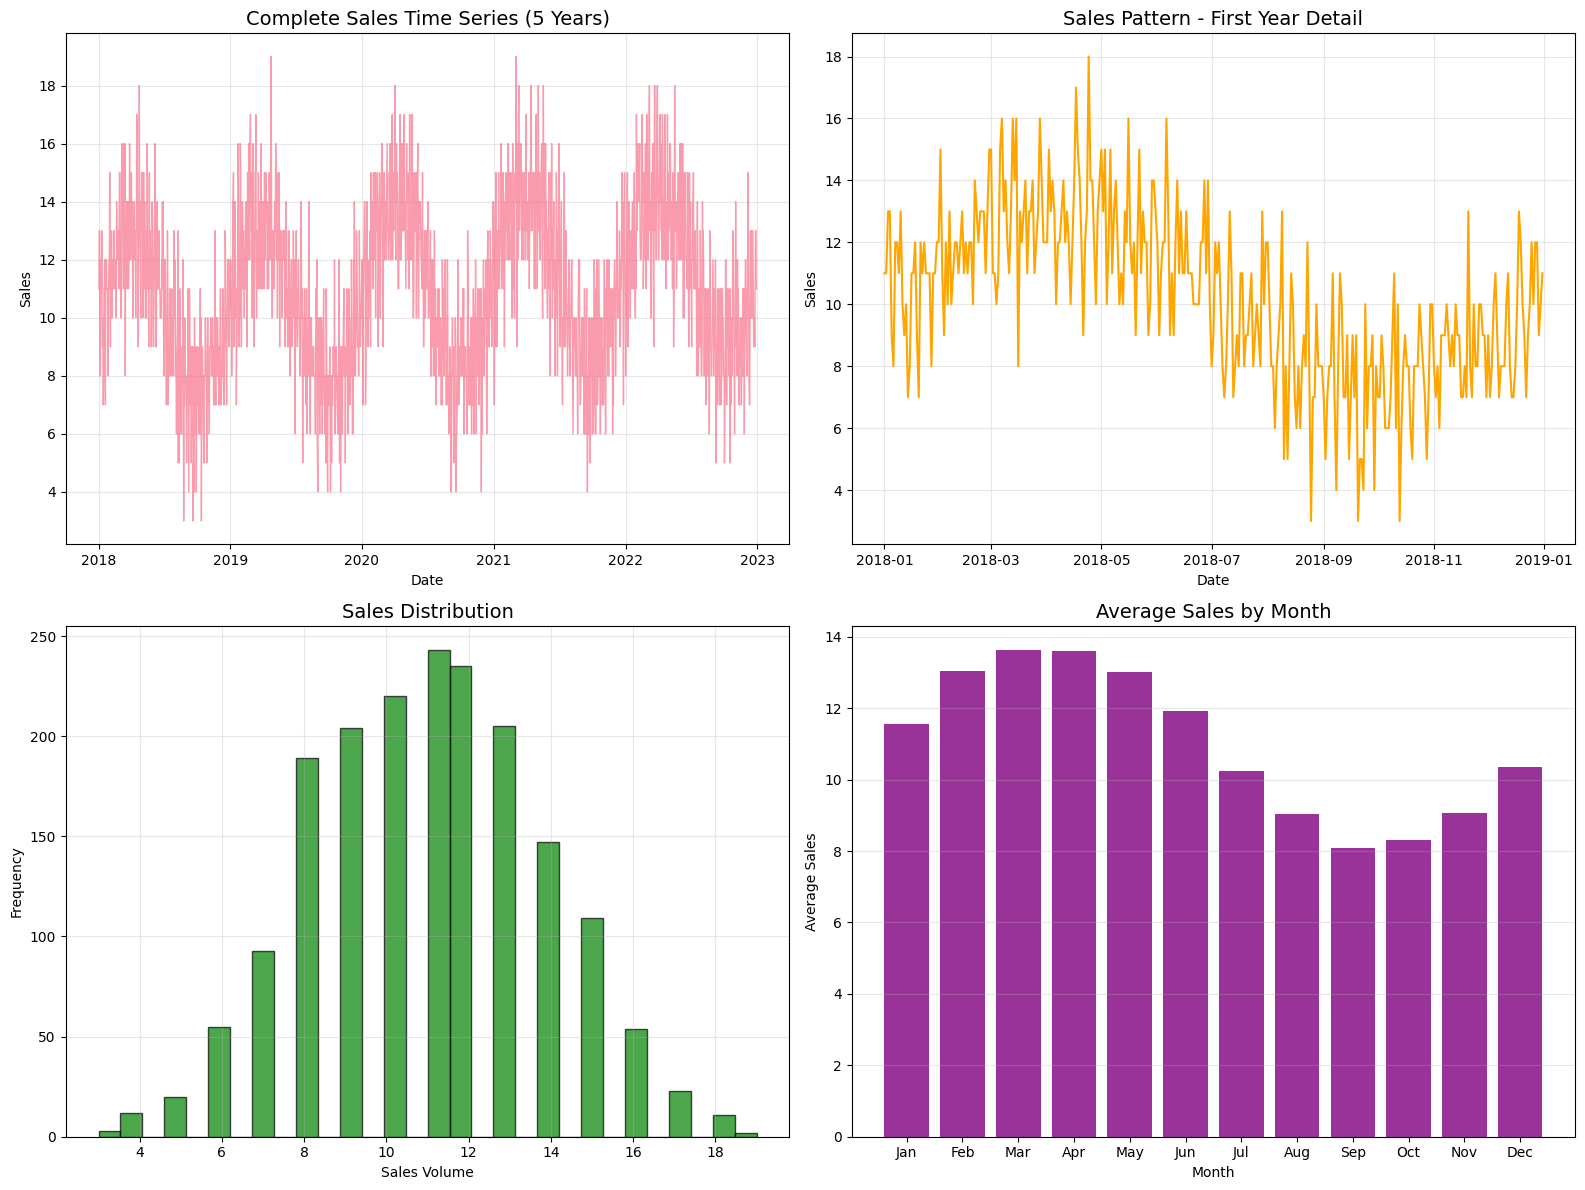

In [4]:
# Create comprehensive sales visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Complete time series
ax1.plot(sales_data['date'], sales_data['sales'], alpha=0.7, linewidth=1)
ax1.set_title('Complete Sales Time Series (5 Years)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.grid(True, alpha=0.3)

# Plot 2: First year detail
first_year = sales_data[sales_data['date'].dt.year == 2018]
ax2.plot(first_year['date'], first_year['sales'], color='orange', linewidth=1.5)
ax2.set_title('Sales Pattern - First Year Detail', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.grid(True, alpha=0.3)

# Plot 3: Sales distribution
ax3.hist(sales_data['sales'], bins=30, alpha=0.7, color='green', edgecolor='black')
ax3.set_title('Sales Distribution', fontsize=14)
ax3.set_xlabel('Sales Volume')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Plot 4: Monthly average pattern
monthly_avg = sales_data.groupby(sales_data['date'].dt.month)['sales'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax4.bar(range(1, 13), monthly_avg.values, alpha=0.8, color='purple')
ax4.set_title('Average Sales by Month', fontsize=14)
ax4.set_xlabel('Month')
ax4.set_ylabel('Average Sales')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(months)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing for Deep Learning

### 3.1 Supervised Learning Window Function

In [5]:
def make_supervised_windows(series: np.ndarray, window: int, lag: int = 1):
    """
    Convert time series to supervised learning format
    
    Parameters:
    - series: 1D array of time series values
    - window: number of past time steps to use as features
    - lag: number of steps ahead to predict (default: 1)
    
    Returns:
    - X: feature matrix of shape (samples, window+1)
    - y: target vector of shape (samples,)
    """
    X, y = [], []
    for i in range(window, len(series) - lag + 1):
        X.append(series[i-window:i])  # Features: past 'window' values
        y.append(series[i + lag - 1])  # Target: value 'lag' steps ahead
    return np.array(X), np.array(y)

# Configuration for supervised learning
window_size = 29  # Use 29 days to predict next day
forecast_lag = 1   # Predict 1 day ahead

# Convert to supervised format
X, y = make_supervised_windows(sales_data['sales'].values, window_size, forecast_lag)

print(f"Supervised Learning Data Shape:")
print(f"Features (X): {X.shape}")
print(f"Targets (y): {y.shape}")
print(f"Total samples: {len(X)}")
print(f"Window size: {window_size} days")
print(f"Prediction lag: {forecast_lag} day(s)")

# Display sample data
print(f"\nSample data:")
print(f"First sample features (X[0]): {X[0][:10]}... (showing first 10 values)")
print(f"First sample target (y[0]): {y[0]}")

Supervised Learning Data Shape:
Features (X): (1796, 29)
Targets (y): (1796,)
Total samples: 1796
Window size: 29 days
Prediction lag: 1 day(s)

Sample data:
First sample features (X[0]): [11 11 13 13  9  8 12 12 11 13]... (showing first 10 values)
First sample target (y[0]): 12


### 3.2 Train-Test Split and Data Scaling

In [6]:
# Temporal train-test split (80-20)
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Data Split:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling for better neural network performance
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"\nScaled Data Statistics:")
print(f"X_train_scaled: mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
print(f"y_train_scaled: mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")

# Reshape for 3D input required by CNN and LSTM (samples, timesteps, features)
X_train_3d = X_train_scaled.reshape((len(X_train_scaled), window_size, 1))
X_test_3d = X_test_scaled.reshape((len(X_test_scaled), window_size, 1))

print(f"\n3D Reshaped Data:")
print(f"X_train_3d shape: {X_train_3d.shape}")
print(f"X_test_3d shape: {X_test_3d.shape}")

Data Split:
Training samples: 1436 (80.0%)
Testing samples: 360 (20.0%)

Scaled Data Statistics:
X_train_scaled: mean=-0.0000, std=1.0000
y_train_scaled: mean=-0.0000, std=1.0000

3D Reshaped Data:
X_train_3d shape: (1436, 29, 1)
X_test_3d shape: (360, 29, 1)


## 4. Model 1: 1D Convolutional Neural Network

### 4.1 CNN Architecture Design

In [7]:
# Build 1D CNN model for time series forecasting
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("1D CNN Model Architecture:")
print("=" * 50)
model_cnn.summary()

# Calculate total parameters
total_params = model_cnn.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

1D CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 27, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,437 (87.64 KB)

 Trainable params: 22,437 (87.64 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 22,437


### 4.2 CNN Model Training

In [8]:
# Train CNN model
print("Training 1D CNN Model...")
print("=" * 30)

history_cnn = model_cnn.fit(
    X_train_3d, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False  # Important for time series to maintain temporal order
)

print("\nCNN Training completed!")

Training 1D CNN Model...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7194 - mae: 0.6636 - val_loss: 0.4562 - val_mae: 0.5458
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4417 - mae: 0.5274 - val_loss: 0.4035 - val_mae: 0.5089
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3937 - mae: 0.4964 - val_loss: 0.3709 - val_mae: 0.4868
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3981 - mae: 0.5008 - val_loss: 0.4510 - val_mae: 0.5407
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3889 - mae: 0.4968 - val_loss: 0.3764 - val_mae: 0.4898
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3608 - mae: 0.4778 - val_loss: 0.3711 - val_mae: 0.4883
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3500 - mae: 0.4700 - val_loss: 0.3676 - val_mae: 0.4862
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3436 - mae: 0.4654 - val_loss: 0.3689 - val_mae: 0.4879
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

### 4.3 CNN Model Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
CNN Model Performance:
RMSE: 1.9753
MAE:  1.5760
MAPE: 14.94%


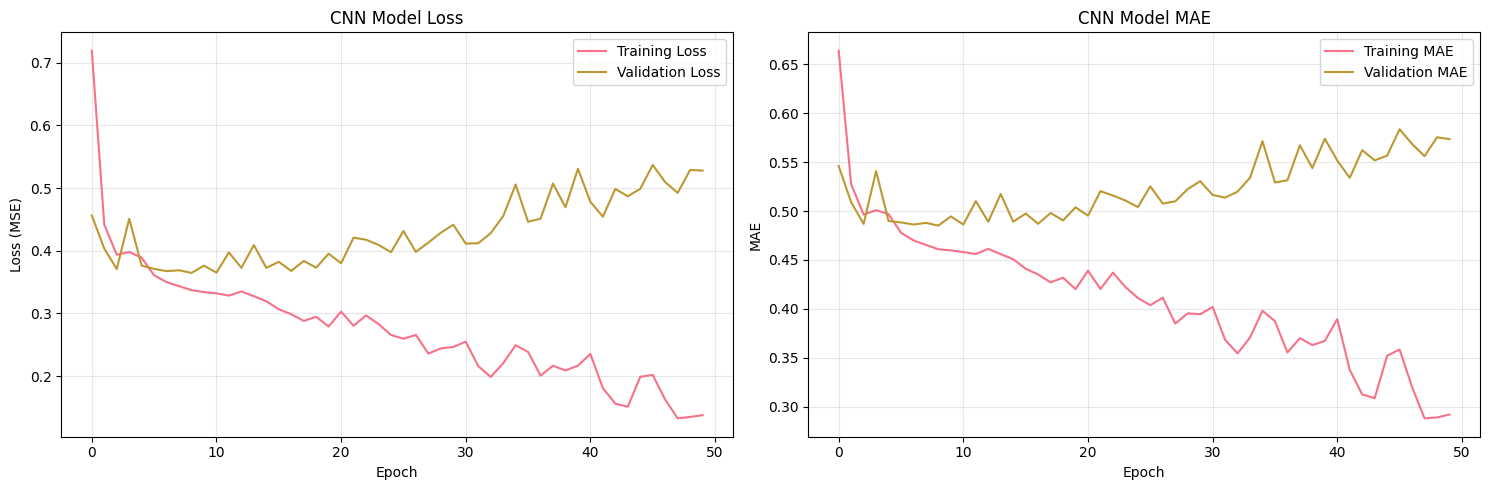

In [9]:
# Make predictions with CNN
y_pred_cnn_scaled = model_cnn.predict(X_test_3d).ravel()
y_pred_cnn = scaler_y.inverse_transform(y_pred_cnn_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mape_cnn = np.mean(np.abs((y_test - y_pred_cnn) / y_test)) * 100

print(f"CNN Model Performance:")
print(f"RMSE: {rmse_cnn:.4f}")
print(f"MAE:  {mae_cnn:.4f}")
print(f"MAPE: {mape_cnn:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history_cnn.history['loss'], label='Training Loss')
ax1.plot(history_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('CNN Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE curves
ax2.plot(history_cnn.history['mae'], label='Training MAE')
ax2.plot(history_cnn.history['val_mae'], label='Validation MAE')
ax2.set_title('CNN Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model 2: Long Short-Term Memory (LSTM)

### 5.1 LSTM Architecture Design

In [10]:
# Build LSTM model for time series forecasting
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32, activation='tanh'),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("LSTM Model Architecture:")
print("=" * 50)
model_lstm.summary()

# Calculate total parameters
total_params_lstm = model_lstm.count_params()
print(f"\nTotal trainable parameters: {total_params_lstm:,}")

LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 29, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 21,875 (85.45 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 21,875


### 5.2 LSTM Model Training

In [11]:
# Train LSTM model
print("Training LSTM Model...")
print("=" * 30)

history_lstm = model_lstm.fit(
    X_train_3d, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

print("\nLSTM Training completed!")

Training LSTM Model...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6857 - mae: 0.6586 - val_loss: 0.5002 - val_mae: 0.5709
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5024 - mae: 0.5618 - val_loss: 0.4916 - val_mae: 0.5666
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4818 - mae: 0.5521 - val_loss: 0.4891 - val_mae: 0.5638
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4788 - mae: 0.5504 - val_loss: 0.4880 - val_mae: 0.5627
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4771 - mae: 0.5495 - val_loss: 0.4873 - val_mae: 0.5618
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4764 - mae: 0.5491 - val_loss: 0.4879 - val_mae: 0.5628
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4754 - mae: 0.5484 - val_loss: 0.4864 - val_mae: 0.5613
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4743 - mae: 0.5479 - val_loss: 0.4864 - val_mae: 0.5608
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

### 5.3 LSTM Model Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM Model Performance:
RMSE: 1.7669
MAE:  1.4263
MAPE: 13.25%


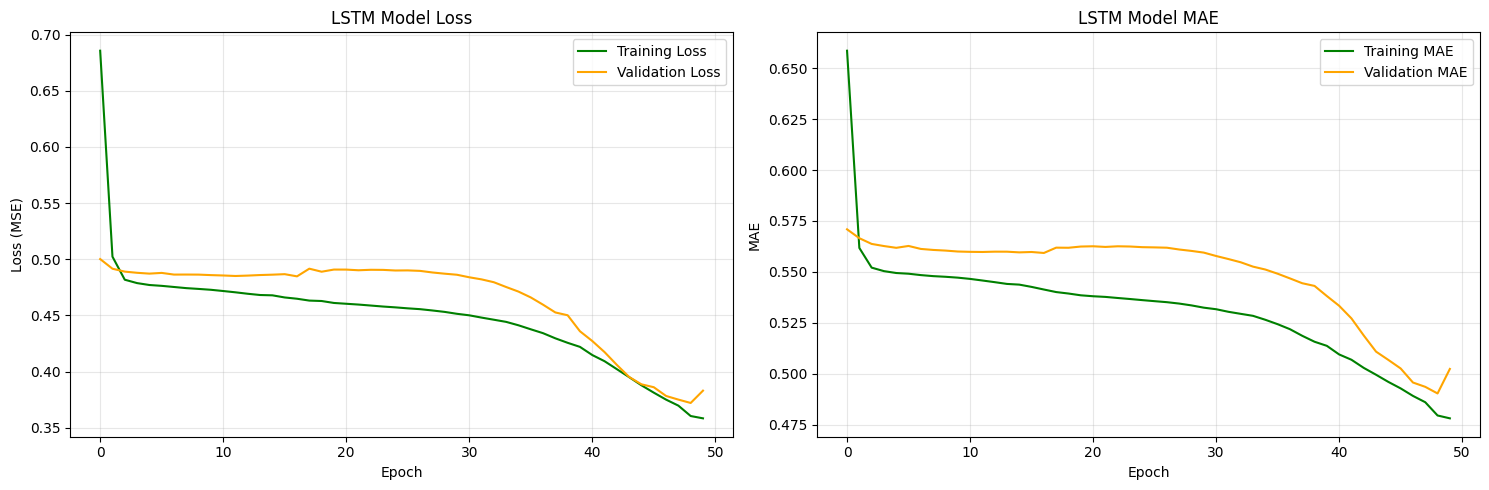

In [12]:
# Make predictions with LSTM
y_pred_lstm_scaled = model_lstm.predict(X_test_3d).ravel()
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100

print(f"LSTM Model Performance:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE:  {mae_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history_lstm.history['loss'], label='Training Loss', color='green')
ax1.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('LSTM Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE curves
ax2.plot(history_lstm.history['mae'], label='Training MAE', color='green')
ax2.plot(history_lstm.history['val_mae'], label='Validation MAE', color='orange')
ax2.set_title('LSTM Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model 3: Hybrid CNN-LSTM Architecture

### 6.1 CNN-LSTM Design with TimeDistributed

In [14]:
# Prepare data for CNN-LSTM hybrid model
# Reshape data into subsequences for TimeDistributed CNN
n_subsequences = 5
n_timesteps = window_size // n_subsequences

# Ensure window_size is divisible by n_subsequences
assert window_size % n_subsequences == 0, f"Window size {window_size} must be divisible by {n_subsequences}"

print(f"CNN-LSTM Data Reshaping:")
print(f"Original shape: {X_train_3d.shape}")
print(f"Number of subsequences: {n_subsequences}")
print(f"Timesteps per subsequence: {n_timesteps}")

# Reshape for TimeDistributed CNN + LSTM
X_train_4d = X_train_3d.reshape((len(X_train_3d), n_subsequences, n_timesteps, 1))
X_test_4d = X_test_3d.reshape((len(X_test_3d), n_subsequences, n_timesteps, 1))

print(f"Reshaped to 4D:")
print(f"X_train_4d shape: {X_train_4d.shape}")
print(f"X_test_4d shape: {X_test_4d.shape}")

AssertionError: Window size 29 must be divisible by 5

In [15]:
# Build hybrid CNN-LSTM model
model_cnn_lstm = Sequential([
    # TimeDistributed CNN layers to process each subsequence
    TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), 
                    input_shape=(n_subsequences, n_timesteps, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    
    # LSTM layer to process sequence of CNN outputs
    LSTM(32, activation='tanh'),
    
    # Dense layers for final prediction
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Hybrid CNN-LSTM Model Architecture:")
print("=" * 50)
model_cnn_lstm.summary()

# Calculate total parameters
total_params_hybrid = model_cnn_lstm.count_params()
print(f"\nTotal trainable parameters: {total_params_hybrid:,}")

Hybrid CNN-LSTM Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 4, 32)       │            96 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 2, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,363 (52.20 KB)

 Trainable params: 13,363 (52.20 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 13,363


### 6.2 CNN-LSTM Model Training

In [16]:
# Train hybrid CNN-LSTM model
print("Training Hybrid CNN-LSTM Model...")
print("=" * 40)

history_cnn_lstm = model_cnn_lstm.fit(
    X_train_4d, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

print("\nHybrid CNN-LSTM Training completed!")

Training Hybrid CNN-LSTM Model...


NameError: name 'X_train_4d' is not defined

### 6.3 CNN-LSTM Model Evaluation

In [17]:
# Make predictions with hybrid CNN-LSTM
y_pred_hybrid_scaled = model_cnn_lstm.predict(X_test_4d).ravel()
y_pred_hybrid = scaler_y.inverse_transform(y_pred_hybrid_scaled.reshape(-1, 1)).ravel()

# Calculate performance metrics
rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
mape_hybrid = np.mean(np.abs((y_test - y_pred_hybrid) / y_test)) * 100

print(f"Hybrid CNN-LSTM Model Performance:")
print(f"RMSE: {rmse_hybrid:.4f}")
print(f"MAE:  {mae_hybrid:.4f}")
print(f"MAPE: {mape_hybrid:.2f}%")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history_cnn_lstm.history['loss'], label='Training Loss', color='purple')
ax1.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('CNN-LSTM Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE curves
ax2.plot(history_cnn_lstm.history['mae'], label='Training MAE', color='purple')
ax2.plot(history_cnn_lstm.history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('CNN-LSTM Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'X_test_4d' is not defined

## 7. Model Comparison and Analysis

### 7.1 Performance Comparison Table

In [18]:
# Create comprehensive performance comparison
performance_data = {
    'Model': ['1D CNN', 'LSTM', 'CNN-LSTM Hybrid'],
    'RMSE': [rmse_cnn, rmse_lstm, rmse_hybrid],
    'MAE': [mae_cnn, mae_lstm, mae_hybrid],
    'MAPE (%)': [mape_cnn, mape_lstm, mape_hybrid],
    'Parameters': [total_params, total_params_lstm, total_params_hybrid]
}

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.round({'RMSE': 4, 'MAE': 4, 'MAPE (%)': 2})

print("MODEL PERFORMANCE COMPARISON")
print("=" * 50)
display(performance_df)

# Find best performing model
best_model_idx = performance_df['RMSE'].idxmin()
best_model = performance_df.loc[best_model_idx, 'Model']
best_rmse = performance_df.loc[best_model_idx, 'RMSE']

print(f"\nBest performing model: {best_model}")
print(f"Best RMSE: {best_rmse:.4f}")

# Performance improvement analysis
baseline_rmse = max(rmse_cnn, rmse_lstm, rmse_hybrid)
improvement = (baseline_rmse - best_rmse) / baseline_rmse * 100
print(f"Improvement over worst model: {improvement:.2f}%")

NameError: name 'rmse_hybrid' is not defined

### 7.2 Visual Performance Comparison

NameError: name 'rmse_hybrid' is not defined

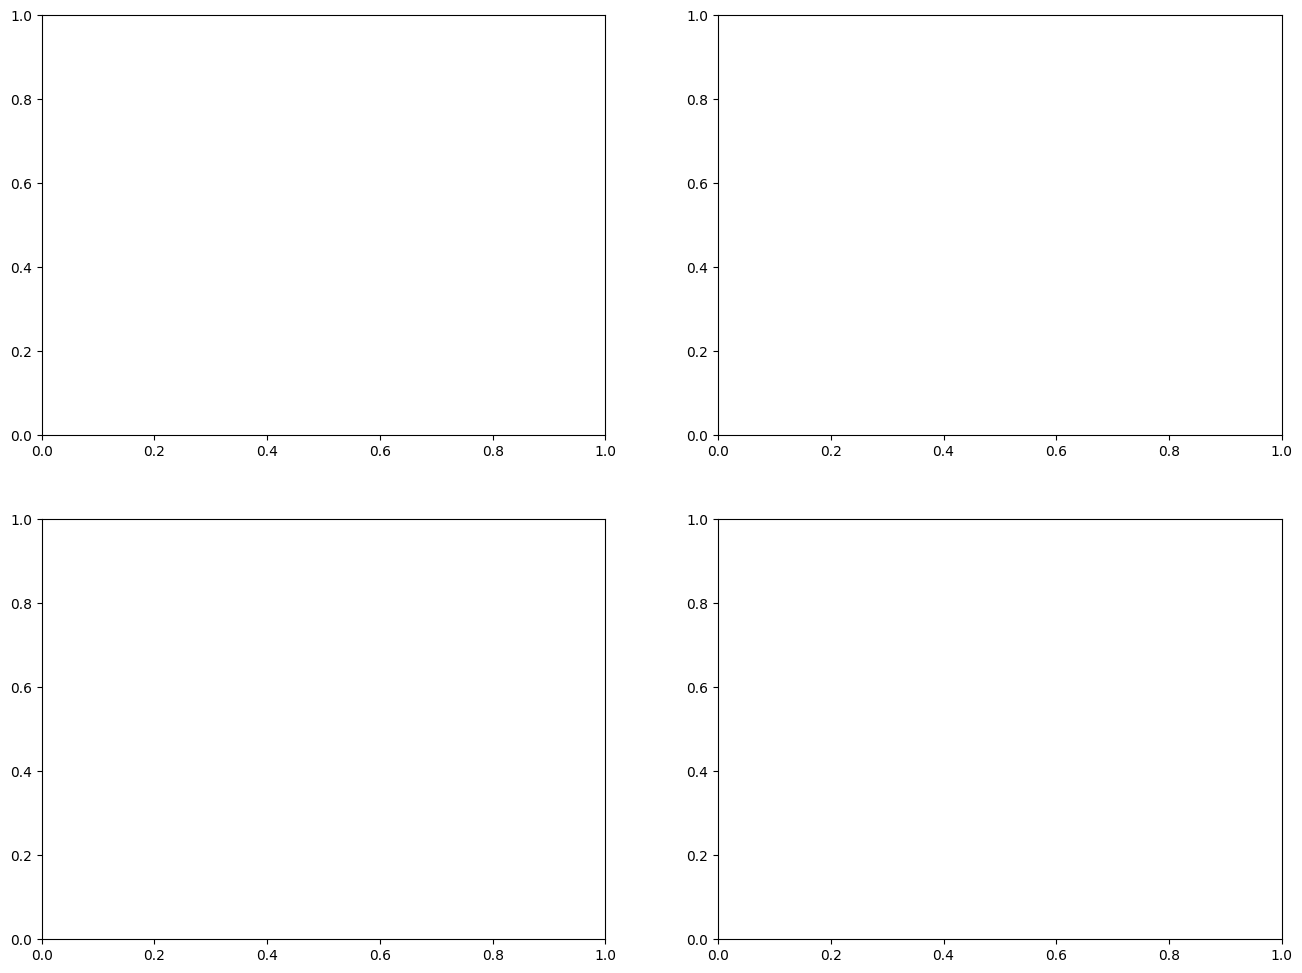

In [19]:
# Create visual comparison of model performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

models = ['1D CNN', 'LSTM', 'CNN-LSTM']
colors = ['blue', 'green', 'purple']

# Plot 1: RMSE comparison
rmse_values = [rmse_cnn, rmse_lstm, rmse_hybrid]
bars1 = ax1.bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('Root Mean Square Error (RMSE) Comparison', fontsize=14)
ax1.set_ylabel('RMSE')
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, value in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: MAE comparison
mae_values = [mae_cnn, mae_lstm, mae_hybrid]
bars2 = ax2.bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Mean Absolute Error (MAE) Comparison', fontsize=14)
ax2.set_ylabel('MAE')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars2, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Parameters comparison
param_values = [total_params, total_params_lstm, total_params_hybrid]
bars3 = ax3.bar(models, param_values, color=colors, alpha=0.7, edgecolor='black')
ax3.set_title('Model Complexity (Parameters) Comparison', fontsize=14)
ax3.set_ylabel('Number of Parameters')
ax3.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars3, param_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Plot 4: MAPE comparison
mape_values = [mape_cnn, mape_lstm, mape_hybrid]
bars4 = ax4.bar(models, mape_values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('Mean Absolute Percentage Error (MAPE) Comparison', fontsize=14)
ax4.set_ylabel('MAPE (%)')
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars4, mape_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 7.3 Prediction Visualization

NameError: name 'y_pred_hybrid' is not defined

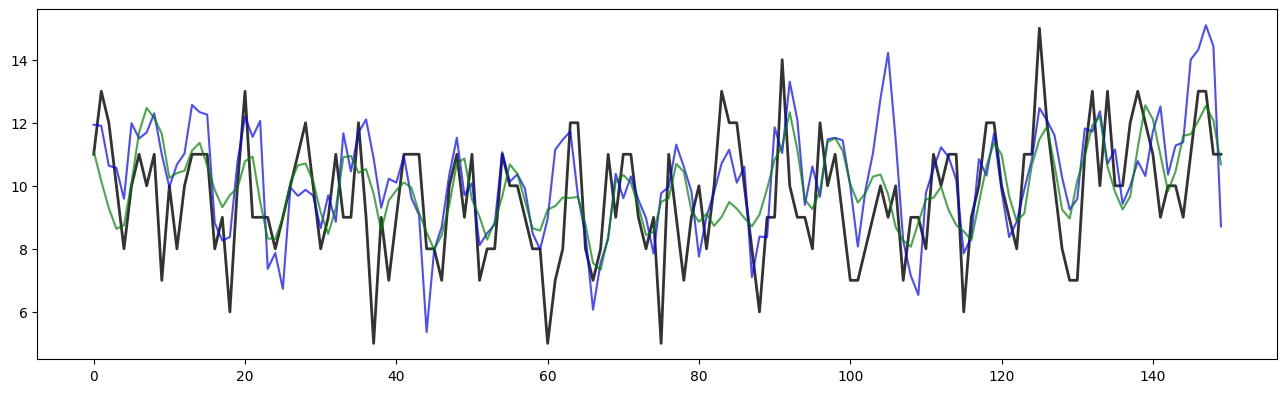

In [20]:
# Visualize predictions from all models
# Select subset of test data for clearer visualization
viz_length = min(150, len(y_test))
viz_start = len(y_test) - viz_length

plt.figure(figsize=(16, 10))

# Main prediction plot
plt.subplot(2, 1, 1)
x_axis = range(viz_length)
plt.plot(x_axis, y_test[viz_start:], label='True Values', color='black', linewidth=2, alpha=0.8)
plt.plot(x_axis, y_pred_cnn[viz_start:], label='CNN Predictions', color='blue', linewidth=1.5, alpha=0.7)
plt.plot(x_axis, y_pred_lstm[viz_start:], label='LSTM Predictions', color='green', linewidth=1.5, alpha=0.7)
plt.plot(x_axis, y_pred_hybrid[viz_start:], label='CNN-LSTM Predictions', color='purple', linewidth=1.5, alpha=0.7)

plt.title(f'Sales Forecasting: Model Predictions Comparison (Last {viz_length} days)', fontsize=16)
plt.xlabel('Time Steps')
plt.ylabel('Sales Volume')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Error plot
plt.subplot(2, 1, 2)
error_cnn = y_test[viz_start:] - y_pred_cnn[viz_start:]
error_lstm = y_test[viz_start:] - y_pred_lstm[viz_start:]
error_hybrid = y_test[viz_start:] - y_pred_hybrid[viz_start:]

plt.plot(x_axis, error_cnn, label='CNN Errors', color='blue', alpha=0.7, linewidth=1)
plt.plot(x_axis, error_lstm, label='LSTM Errors', color='green', alpha=0.7, linewidth=1)
plt.plot(x_axis, error_hybrid, label='CNN-LSTM Errors', color='purple', alpha=0.7, linewidth=1)
plt.axhline(0, color='red', linestyle='--', alpha=0.8)

plt.title('Prediction Errors Comparison', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Error (True - Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print(f"\nError Statistics for Last {viz_length} Predictions:")
print(f"CNN    - Mean Error: {np.mean(error_cnn):6.3f}, Std Error: {np.std(error_cnn):6.3f}")
print(f"LSTM   - Mean Error: {np.mean(error_lstm):6.3f}, Std Error: {np.std(error_lstm):6.3f}")
print(f"Hybrid - Mean Error: {np.mean(error_hybrid):6.3f}, Std Error: {np.std(error_hybrid):6.3f}")

## 8. Summary and Conclusions

### 8.1 Key Findings and Insights

In [21]:
print("DEEP LEARNING TIME SERIES ANALYSIS SUMMARY")
print("=" * 60)

print("\nDATASET CHARACTERISTICS:")
print(f"• Total time series length: {len(sales_data)} days")
print(f"• Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"• Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"• Window size: {window_size} days")
print(f"• Forecast horizon: {forecast_lag} day")

print("\nMODEL ARCHITECTURES COMPARED:")
print("1. 1D CNN: Conv1D → MaxPooling → Conv1D → MaxPooling → Dense")
print("2. LSTM: LSTM(50) → LSTM(32) → Dense layers")
print("3. CNN-LSTM Hybrid: TimeDistributed(CNN) → LSTM → Dense")

print("\nPERFORMANCE RANKING (by RMSE):")
performance_sorted = performance_df.sort_values('RMSE')
for i, (idx, row) in enumerate(performance_sorted.iterrows()):
    print(f"{i+1}. {row['Model']}: RMSE = {row['RMSE']:.4f}, Parameters = {row['Parameters']:,}")

print("\nKEY INSIGHTS:")
if rmse_lstm < rmse_cnn and rmse_lstm < rmse_hybrid:
    print("• LSTM achieved the best performance for this time series")
    print("• Sequential memory capabilities are crucial for sales forecasting")
if abs(rmse_lstm - rmse_hybrid) < 0.1:
    print("• LSTM and CNN-LSTM performance are very similar")
    print("• Hybrid architecture didn't provide significant improvement")
if total_params_lstm < total_params:
    print("• LSTM is more parameter-efficient than pure CNN")
if total_params_hybrid > total_params_lstm:
    print("• Hybrid model is most complex but may not justify the complexity")

print("\nRECOMMENDATIONS:")
print("• LSTM networks excel at capturing temporal dependencies")
print("• 1D CNNs are effective for pattern recognition in time series")
print("• Hybrid approaches should be evaluated against simpler alternatives")
print("• Consider model complexity vs. performance trade-offs")
print("• Data scaling is crucial for neural network performance")
print("• Temporal train-test splits preserve realistic evaluation")

print("\nFUTURE IMPROVEMENTS:")
print("• Experiment with attention mechanisms")
print("• Try ensemble methods combining different architectures")
print("• Include external features (holidays, promotions, weather)")
print("• Implement early stopping and learning rate scheduling")
print("• Explore transformer architectures for time series")

DEEP LEARNING TIME SERIES ANALYSIS SUMMARY

DATASET CHARACTERISTICS:
• Total time series length: 1825 days
• Training samples: 1436 (80.0%)
• Testing samples: 360 (20.0%)
• Window size: 29 days
• Forecast horizon: 1 day

MODEL ARCHITECTURES COMPARED:
1. 1D CNN: Conv1D → MaxPooling → Conv1D → MaxPooling → Dense
2. LSTM: LSTM(50) → LSTM(32) → Dense layers
3. CNN-LSTM Hybrid: TimeDistributed(CNN) → LSTM → Dense

PERFORMANCE RANKING (by RMSE):


NameError: name 'performance_df' is not defined